# MTA Turnstile Data Analysis
## Benson Challenges

### Table of Contents:
 - [**Challenge 1**](#1)
 - [**Challenge 2**](#2)
 - [**Challenge 3**](#3)
 - [**Challenge 4**](#4)
 - [**Challenge 5**](#5)
 - [**Challenge 6**](#6)
 - [**Challenge 7**](#7)
 - [**Challenge 8**](#8)
 - [**Challenge 9**](#9)
 - [**Challenge 10**](#10)

In [2]:
# Import Dependencies
from GetDataURLs import GetDataURLs
import csv
from collections import defaultdict
import dateutil.parser

# For display
import pprint
import matplotlib.pyplot as plt
%matplotlib inline

### <a id='1'></a>Challenge 1:

In [6]:
def download_and_process_raw_data(raw_HTML_data_URLs):
    """
    In: 
    raw_HTML_data_URLs = A .txt file with unparsed HTML code containing the desired URLs to the data
    
    Out:
    raw_data_dict = A dictionary of the raw data with keys as a tuple: ("C/A", "UNIT", "SCP", "STATION - LINENAME")
    """
    
    # Parse raw HTML using regular expressions to get URLs to data files
    link_list = GetDataURLs(raw_HTML_data_URLs)
    
    #Split each URL by "/" and take the last item to the file name and extension without the past (e.g. "data.txt")
    file_list = [link.split("/")[-1] for link in link_list]
    
    raw_data_dict = {}
    
    for link, file in zip(link_list, file_list):
        """
        Download the raw data
        
        To save time do this ONLY ONCE, and then comment out!
        """
        # !curl -O http://web.mta.info/developers/$link

        # Open files from the "data" folder
        with open("./data/" + file) as f:
            reader = csv.reader(f)
            rows = [[cell.strip() for cell in row] for row in reader]

        
        # Check that the data file headers are correct and remove
        assert rows.pop(0) == ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME',
                           'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES',
                           'EXITS']

        for row in rows:
            # Make key, appending LINENAME to STATION after sorting the characters in LINENAME to ensure consistency
            dict_key = tuple([row[0], row[1], row[2], row[3] + " - " + "".join(sorted([c for c in row[4]]))])
            
            raw_data_dict.setdefault(dict_key, []).append(row[4:])

    return raw_data_dict

raw_data_dict = download_and_process_raw_data("rawHTMLdataURLs.txt")

### <a id='2'></a>Challenge 2:

In [8]:
def raw_dict_to_datetime_and_entries(d):
    """
    In:
    d = raw data dictionary
    
    Out:
    new_dict = new dictionary with date and time strings combined and converted to dateime, 
               and turnstile entries converted from raw total to net new entries (integer)
    """
    new_dict = defaultdict()
    
    for k, lst in d.items():
        
        new_dict[k] = []
        
        for data_row in lst:
            # Find dates and time data points and combine into one
            datetime_str = str(data_row[2]) + " " + str(data_row[3])
            
            # Use dateutil to convert to datetime
            new_date = dateutil.parser.parse(datetime_str)
            
            #Get turnstile entries count and convert to integer
            entries = int(data_row[5])
            
            # Append datetime and entries to new data row list
            new_data_row = []
            new_data_row.append(new_date)
            new_data_row.append(entries)
            
            # Append new data row list to new dict. under the key
            new_dict[k].append(new_data_row)
            
    for k, lst in new_dict.items():
        lst = sorted(lst, key=lambda x: x[0])
        
        for i, data_row in enumerate(lst):
            if i == 0:
                data_row.append(0)
            else:
                data_row.append(lst[i][1] - lst[i-1][1])
            
        for data_row in lst:
            data_row.pop(-2)
    
    return new_dict

processed_dict = raw_dict_to_datetime_and_entries(raw_data_dict)

In [10]:
def remove_entry_count_outliers(d):
    """
    In: 
    d = processed dictionary with net entry counts rather than raw totals
    
    Out: 
    new dictionary removing outliers (negative entries or over 10,000 entries per 4 hours)
    """
    return {turnstile: [(time, count) for (time, count) in rows if 0 <= count <= 10000]
                for turnstile, rows in d.items()}

processed_dict = remove_entry_count_outliers(processed_dict)

### <a id='3'></a>Challenge 3:
The counts (for the majority of data points) are for **every 4 hours** (though there are some turnstiles reporting longer or shorter times between reports).

In [16]:
def roll_up_by_date(d):
    """
    In:
    d = processed dictionary with net entry counts rather than raw totals and outliers removed
    
    Out:
    new_dict = new dictionary with all the readings within each date combined for each key (turnstile)
    """
    new_dict = defaultdict()
    for k, list_of_lists in d.items():
        sorted_LoL = sorted(list_of_lists)  # Sort so that dates are in order
        
        new_dict[k] = []
        
        last_date = ""
        total = 0
        
        for i, data_list in enumerate(sorted_LoL):
            try:
                date = data_list[0].date()
            except AttributeError:
                date = data_list[0]  # If object is already a date, no need to call .date()
            entries = data_list[1]
            
            if i == 0:
                last_date = date
            
            if date == last_date:
                total += entries
            else:
                new_dict[k].append([last_date, total])
                last_date = date
                total = entries
                
        new_dict[k].append([last_date, total])
                
    return new_dict

grouped_dates_dict = roll_up_by_date(processed_dict)

### <a id='4'></a>Challenge 4:

In [18]:
# See begining of file for the "%matplotlib inline" and "import matplotlib.pyplot as plt"

def get_by_date_plot_data(d, k):
    """
    In:
    d = dictionary with grouped dates for each turnstile
    k = key (e.g. turnstile, station, etc.) whose data you want to plot
    
    Out:
    (dates, counts) = tuple with dates and entry counts for plotting
    """
    dates = [x[0] for x in d[k]]
    counts = [x[1] for x in d[k]]
    return dates, counts

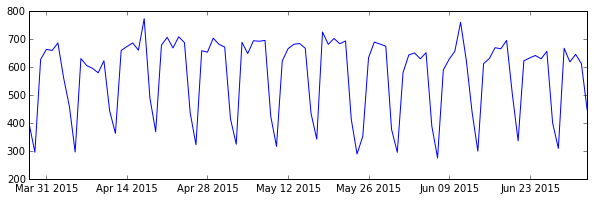

In [19]:
def plot_time_series(datetimes, counts):
    """
    In:
    datetimes = list of dates and/or times to plot (x-axis values)
    counts = list of counts or other data to plot (y-axis values)
    
    Out:
    Plot of counts by datetime
    """
    plt.figure(figsize=(10,3))
    plt.plot(datetimes, counts)
    
dates, counts = get_by_date_plot_data(grouped_dates_dict, list(grouped_dates_dict.keys())[0])
plot_time_series(dates, counts)

### <a id='5'></a>Challenge 5:

In [20]:
def roll_up_SCPs(d):
    """
    In:
    d = processed dictionary grouped by date for each turnstile
    
    Out:
    new_dict = dictionary rolling up individual turnstiles to the ("C/A", "UNIT", "STATION - LINENAME") level
    """
    new_dict = defaultdict()
    
    for k, list_of_lists in d.items():
        new_key = tuple(k[:2] + (k[3],))
        try:
            new_dict[new_key] += list_of_lists
        except KeyError:
            # if there is no entry for this key, make one
            new_dict[new_key] = list_of_lists
        
    # Re-combine dates since there will now be multiple instances of each date again given the SCP roll up
    new_dict = roll_up_by_date(new_dict)
    
    return new_dict

SCPs_rolled_dict = roll_up_SCPs(grouped_dates_dict)

### <a id='6'></a>Challenge 6:

In [22]:
def roll_up_to_stations(d):
    """
    In:
    d = processed dictionary grouped by date with rolled up turnstile SCPs
    
    Out:
    new_dict = dictionary rolling up all turnstiles to the STATION - LINENAME" level
    """
    new_dict = defaultdict()
    
    for k, list_of_lists in d.items():
        new_key = k[2]  # "STATION - LINENAME"
        try:
            new_dict[new_key] += list_of_lists
        except KeyError:
            # if there is no entry for this key, make one
            new_dict[new_key] = list_of_lists
        
    # Re-combine dates since there will now be multiple instances of each date again given the roll up
    new_dict = roll_up_by_date(new_dict)
    
    return new_dict

by_station_dict = roll_up_to_stations(SCPs_rolled_dict)

### <a id='7'></a>Challenge 7:

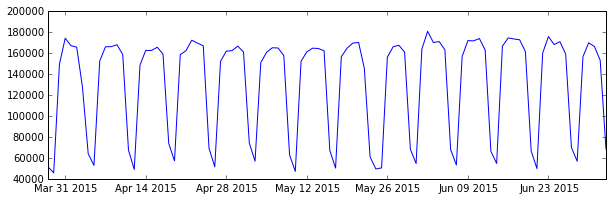

In [24]:
dates, counts = get_by_date_plot_data(by_station_dict, list(by_station_dict.keys())[0])
plot_time_series(dates, counts)

### <a id='8'></a>Challenge 8:

In [27]:
def split_station_into_weekly_lists(d, station):
    """
    In:
    d = processed dictionary grouped by date, rolled up by station
    station = station for which you want get weekly lists of entry counts by day
    
    Out:
    list_of_weekly_entries = list of weekly lists of count of entries (Sunday - Saturday)
    """
    list_of_weekly_entries = []
    week_entries = []
    
    for i, data_list in enumerate(sorted(d[station])):  # Sort to make sure dates are in order
        date = data_list[0]
        weekday = date.weekday()  # Returns weekday number where 0 = Monday
        entries = data_list[1]
        
        if (i == 0) and (weekday != 6):  # If first item in list and weekday is NOT Sunday
            days_ahead = (7 + weekday) - 6
            for i in range(days_ahead):
                week_entries.append(0)
        
        week_entries.append(entries)
        
        if (weekday == 5):  # If Saturday (last day in week)
            list_of_weekly_entries.append(week_entries)
            week_entries = []
        
    last_week_len = len(week_entries)
    if last_week_len != 0:
        for i in range(7 - last_week_len):
            week_entries.append(0)

    list_of_weekly_entries.append(week_entries)
    
    return list_of_weekly_entries

weekly_lists = split_station_into_weekly_lists(by_station_dict, list(by_station_dict.keys())[0])

In [29]:
def get_by_weekday_plot_data(one_week_list):
    """
    In:
    one_week_list = list of counts corresponding to each weekday Sunday - Saturday
    
    Out:
    (weekydays, counts) = tuple of weekday numbers and counts to plot
    """
    # weekdays = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
    weekdays = [x + 1 for x in range(7)]
    counts = one_week_list
    return weekdays, counts

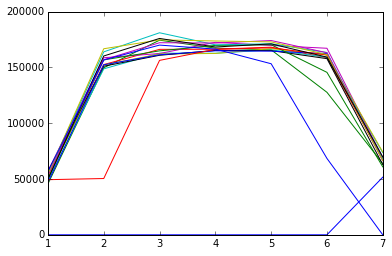

In [30]:
def plot_weekly_rainbow_chart(weekly_lists):
    """
    In:
    weekly_lists = list of weekly lists of count of entries (Sunday - Saturday) to be plotted
    
    Out:
    "Rainbow" chart plot
    """
    for week in weekly_lists:
        weekdays, counts = get_by_weekday_plot_data(week)
        plt.plot(weekdays, counts)

plot_weekly_rainbow_chart(weekly_lists)

### <a id='9'></a>Challenge 9:

In [31]:
def roll_all_dates_by_stations(d):
    """
    In:
    d = processed dictionary grouped by date with rolled up stations
    
    Out:
    Dictionary with all dates rolled up to a single value for each station
    """
    return {k: sum([lst[1] for lst in LoLs]) for k, LoLs in d.items()}

all_dates_rolled = sorted(roll_all_dates_by_stations(by_station_dict).items(), key=lambda x: x[1], reverse=True)

### <a id='10'></a>Challenge 10:

(array([ 359.,   76.,   16.,    6.,    3.,    3.,    1.,    1.,    1.,    1.]),
 array([  8.45700000e+03,   1.29658760e+06,   2.58471820e+06,
          3.87284880e+06,   5.16097940e+06,   6.44911000e+06,
          7.73724060e+06,   9.02537120e+06,   1.03135018e+07,
          1.16016324e+07,   1.28897630e+07]),
 <a list of 10 Patch objects>)

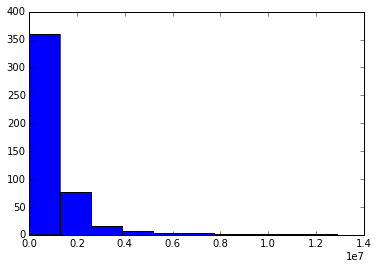

In [34]:
counts = [count for station, count in all_dates_rolled]
plt.hist(counts)

<Container object of 467 artists>

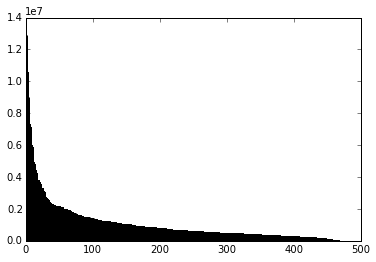

In [35]:
indices = range(1, len(counts) + 1)
plt.bar(indices, counts)